In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [57]:
df = pd.read_csv('linear_regression.csv', index_col=0)

In [58]:
#Przeformatowanie zmiennej kategorycznej tak by zawierała liczby zamiast napisy
df['X6'] = df['X6'].apply(lambda kolor: 0 if kolor == 'red' else 1)
#df['Intercept']=np.ones((100,1)) - dopisanie kolumny jedynek - pominąć, jeżeli jest to zaimplementowane w metodzie .fit()

In [59]:
describing=df.iloc[:,[0,1,2,3,4,5,-1]].to_numpy() #Wybranie wektora danych wejściowych
result1=df.loc[:,'Y1'].to_numpy() #Wybranie wektora odpowiedzi (Y1 jest najbardziej interesujące, pozostałe pomijamy)

In [60]:
#Podział wektorów wejściowych i odpowiedzi na zestawy uczące oraz walidacyjne (testowe)
X_train, X_val, Y_train, Y_val = train_test_split(describing, result1, test_size=0.3)

In [61]:
#Uruchamiać TYLKO RAZ! - Musimy zmienić kształty macierzy wejściowych tak by pasowały do poniższych wzorów
X_train=X_train.transpose()
X_val=X_val.transpose()
Y_train=Y_train.reshape((1,70))
Y_val=Y_val.reshape((1,30))

In [62]:
X_train

array([[ 5.43031040e+00,  8.65356810e+00,  7.59332200e+00,
         9.92806790e+00,  1.75677390e+00,  1.88491320e+00,
         4.90173750e+00,  4.86692100e-01,  9.33755600e-01,
         9.69587680e+00,  7.45355850e+00,  2.64368080e+00,
         5.91976860e+00,  5.41085370e+00,  5.17163260e+00,
         7.98355900e-01,  2.04575480e+00,  3.66848590e+00,
         6.23516500e-01,  8.94694830e+00,  4.11789750e+00,
         2.86825620e+00,  2.17824240e+00,  8.94445890e+00,
         2.09860840e+00,  6.92552300e+00,  3.05220780e+00,
         8.94860210e+00,  5.54312000e-02,  8.35805040e+00,
         1.07394640e+00,  5.53964430e+00,  3.11757310e+00,
         5.95759780e+00,  1.79179310e+00,  4.45784560e+00,
         9.79672760e+00,  5.44100600e-01,  5.08913010e+00,
         1.87095900e-01,  2.48137060e+00,  6.77117780e+00,
         6.02993400e+00,  2.93490800e+00,  1.23427430e+00,
         9.84123050e+00,  6.43911410e+00,  9.58578090e+00,
         7.68740690e+00,  9.62290000e-01,  1.63784470e+0

## Gradient descent

$$g(\mathbf x_i)=\Beta^T\mathbf{x_i}+\beta_0,\ \ i=1,\dots,m$$
$$\tilde{\mathbf x_i}=\begin{bmatrix} 1 \\ x_1 \\ x_2 \\ \vdots \\ x_n\end{bmatrix}$$
$$\tilde{B}=\begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \\ \vdots \\ \beta_n \end{bmatrix}$$
$$g(\mathbf x_i)=\tilde{B}^T\tilde{\mathbf x_i},\ \ i=1,\dots,m$$
$$\tilde X=\begin{bmatrix} 1 & 1 & \dots & 1 \\ x_{11} & x_{12} & \dots & x_{1m} \\ x_{21} & x_{22} & \dots & x_{2m} \\ \vdots & \vdots & \ddots & \vdots \\ x_{n1} & x_{n2} & \dots & x_{nm}\end{bmatrix}_{n\times m}=\begin{bmatrix}\tilde{\mathbf x}_1 & \tilde{\mathbf x}_2 & \dots & \tilde{\mathbf x}_m\end{bmatrix},\ \ \ Y=\begin{bmatrix} y_1 & y_2 &\dots & y_m\end{bmatrix}_{1\times m}$$
$$L(\tilde \Beta)=\frac 1m\sum_{i=1}^m\bigl(\tilde B^T\tilde{\mathbf x_i}-y_i\bigr)^2+\lambda\Vert\tilde\Beta\Vert^2$$
$$L(\tilde \Beta)=\frac 1m\bigl(\tilde\Beta^T\tilde{\mathbf X}-\mathbf Y\bigr)\bigl(\tilde\Beta^T\tilde{\mathbf X}-\mathbf Y\bigr)^T+\lambda\tilde{\Beta}^T\tilde{\Beta}$$
$$\nabla L=\frac 2m\bigl(\tilde{\Beta}^T\tilde{\mathbf X}-\mathbf{Y}\bigr)\tilde{\mathbf X}^T+2\lambda\tilde{\Beta}$$

In [63]:
class LinearRegr:
    def fit(self, X_train : np.ndarray, Y_train : np.ndarray,
            validation: bool = False, 
            X_val : np.ndarray | None = None, Y_val : np.ndarray | None = None,
            eta: float = 0.05, epochs: int = 50, 
            verbose: bool = True, plot : bool = True):
        n,m=X_train.shape
        self.Beta=np.zeros((n+1,1)) # wektor Beta

        # Uwaga: przed zastosowaniem wzoru do X nalezy dopisac wiersz zlozony z jedynek.
        X_train = np.vstack((np.ones((1,m)), X_train))
        #Jeśli opcja validation jest False, to walidacja jest przeprowadzana na wektorach uczących (domyślnie)
        #Jeśli opcja validation jest True, to sprawdzamy czy wprowadzono wektory testowe X_val i Y_val
        if not validation:
            X_val, Y_val =X_train, Y_train
        else:
            if X_val is None or Y_val is None:
                raise ValueError("If validation is False, X_val and Y_val are required")
            X_val = np.vstack((np.ones((1, Y_val.shape[1])), X_val)) # tu sie zastanowic
        testy=[]
        
        #Pętla optymalizacyjna w metodzie GD
        for k in range(epochs):
            #############################################
            #Aktualizacja self.Beta zgodnie z metodą GD
            #############################################
            ypred = self.Beta.transpose()@X_train
            grad = (2/m)*(X_train@(ypred - Y_train).transpose())
            self.Beta -= eta*grad
            
             
            test=(1/m*(temp:=(self.Beta.transpose()@X_val-Y_val))@temp.transpose())[0,0]
            #Jeśli opcja verbose jest wybrana, to w każdym kroku pętli wyświetlamy aktualną wartość funkcji straty dla wektorów walidujących
            if verbose:
                print(f"Epoch: {k}, Loss function for validation vector: {test:.4f}")
            if plot:
                testy.append(test)


        #Jeśli opcja plot jest wybrana, to tworzymy wykres wartości funkcji straty po każdym kroku optymalizacji
        if plot:
            plt.plot(np.arange(epochs),testy,ls='-.')
            plt.title('Value of the loss function for validation vector after each epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()
            
        return self
    
    def predict(self, X : np.ndarray) -> np.ndarray:
        n, m = X.shape
        X = np.vstack((np.ones((1,m)), X))
        Y_pred = self.Beta.transpose() @ X
        return Y_pred

Epoch: 0, Loss function for validation vector: 42.1754
Epoch: 1, Loss function for validation vector: 35.1321
Epoch: 2, Loss function for validation vector: 31.0953
Epoch: 3, Loss function for validation vector: 28.5407
Epoch: 4, Loss function for validation vector: 26.7314
Epoch: 5, Loss function for validation vector: 25.3102
Epoch: 6, Loss function for validation vector: 24.1034
Epoch: 7, Loss function for validation vector: 23.0258
Epoch: 8, Loss function for validation vector: 22.0350
Epoch: 9, Loss function for validation vector: 21.1093
Epoch: 10, Loss function for validation vector: 20.2371
Epoch: 11, Loss function for validation vector: 19.4116
Epoch: 12, Loss function for validation vector: 18.6284
Epoch: 13, Loss function for validation vector: 17.8846
Epoch: 14, Loss function for validation vector: 17.1777
Epoch: 15, Loss function for validation vector: 16.5055
Epoch: 16, Loss function for validation vector: 15.8662
Epoch: 17, Loss function for validation vector: 15.2581
Ep

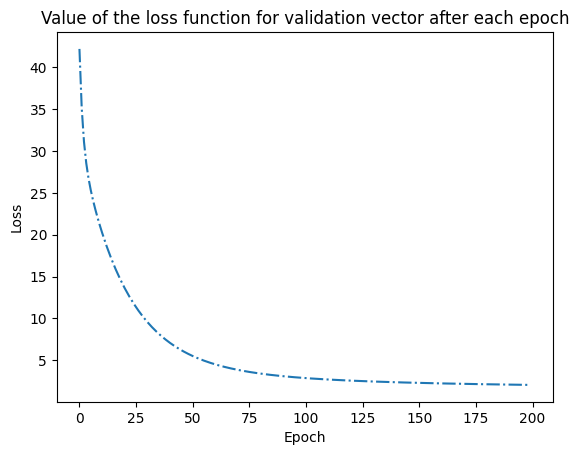

array([[-0.37274841,  8.8356339 ,  4.5316009 ,  2.24479001,  9.85552626,
         5.05443564,  5.28104021,  1.58096324, 13.53134197,  4.23120286,
         4.2385844 ,  8.85437454,  7.12447284,  4.77217409,  8.53340823,
         9.53326039,  3.63181629,  0.3745219 ,  8.94956895,  1.14230266,
        12.11491575,  6.92487385,  9.0241526 , 14.95930198,  6.07618297,
         7.25419682,  2.12721986,  2.09241146,  5.24267735,  6.9598014 ]])

In [64]:
model = LinearRegr().fit(X_train, Y_train, X_val=X_val, Y_val=Y_val, eta=0.001, epochs=200)
Y_pred = model.predict(X_val)
Y_pred

## Stochastic gradient descent

$$L(\tilde\Beta)=\frac 1m\sum_{i=1}^m\bigl(\tilde B^T\tilde{\mathbf x_i}-y_i\bigr)^2+\lambda\Vert\tilde\Beta\Vert^2=\frac{1}{m}\sum_{i=1}^m\bigl[\bigl(\tilde B^T\tilde{\mathbf x_i}-y_i\bigr)^2+\lambda\Vert\tilde\Beta\Vert^2\big]=\frac 1m\sum_{i=1}^m f_i(\tilde\Beta)$$

Niech $I$ będzie zmienną losową o rozkładzie jednostajnym na $\{1,\dots,m\}$. Łatwo sprawdzić, że
$$\mathbb E\nabla f_I(\tilde \Beta)=\nabla L(\tilde\Beta).$$
Zatem $\nabla f_I(\tilde \Beta)$ jest nieobciążonym estymatorem $\nabla L(\tilde\Beta)$. Dzięki temu, w każdym kroku zamiast obliczać gradient dla całego zestawu danych, wystarczy nam estymować go, obliczając go po kolei dla każdej pary $(\mathbf x_i,y_i)$ - należy jednak pamiętać, że istotne jest tu "tasowanie" indeksów.

In [74]:
class RidgeRegr:
    def __init__(self,l : float = 0.05):
        self.l=l
    def fit(self, X_train : np.ndarray, Y_train : np.ndarray,
            validation: bool = False, 
            X_val : np.ndarray | None = None, Y_val : np.ndarray | None = None,
            eta: float = 0.05, epochs: int = 50, 
            verbose: bool = True, plot : bool = True):
        n,m=X_train.shape
        self.Beta=np.zeros((n+1,1))

        # Uwaga: przed zastosowaniem wzoru do X nalezy dopisac wiersz zlozony z jedynek.
        X_train = np.vstack((np.ones((1,m)), X_train))
        #Jeśli opcja validation jest False, to walidacja jest przeprowadzana na wektorach uczących (domyślnie)
        #Jeśli opcja validation jest True, to sprawdzamy czy wprowadzono wektory testowe X_val i Y_val
        if not validation:
            X_val, Y_val =X_train, Y_train
        else:
            if X_val is None or Y_val is None:
                raise ValueError("If validation is False, X_val and Y_val are required")
            X_val = np.vstack((np.ones((1, Y_val.shape[1])), X_val))
        testy = []
        
        #Pętla optymalizacyjna w metodzie SGD (należy uwzględnić tasowanie indeksów)
        for k in range(epochs):
            #############################################
            #Aktualizacja self.Beta zgodnie z metodą SGD
            #############################################
            # tasowanie indeksow
            indeksy = np.random.permutation(m)

            for i in indeksy:
                xi = X_train[:, i:i+1] # wybieramy ita probke z wszystkimy cechami
                yi = Y_train[:, i:i+1]
                ypred = self.Beta.transpose()@xi
                grad_mse = 2*(xi@(ypred - yi))
                grad_rdg = 2*self.l*self.Beta
                grad = grad_mse + grad_rdg 
                grad = grad/np.linalg.norm(grad)
                self.Beta -= eta*grad
                
            test=(1/m*(temp:=(self.Beta.transpose()@X_val-Y_val))@temp.transpose())[0,0]\
                +self.l*np.linalg.norm(self.Beta)**2
            #Jeśli opcja verbose jest wybrana, to w każdym kroku pętli wyświetlamy aktualną wartość funkcji straty dla wektorów walidujących
            if verbose:
                print(f"Epoch: {k}, Loss function for validation vector: {test:.4f}")
            if plot:
                testy.append(test)

        #Jeśli opcja plot jest wybrana, to tworzymy wykres wartości funkcji straty po każdym kroku optymalizacji
        if plot:
            plt.plot(np.arange(epochs),testy,ls='-.')
            plt.title('Value of the loss function for validation vector after each epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()

        return self
    
    def predict(self, X : np.ndarray) -> np.ndarray:
        n, m = X.shape
        X = np.vstack((np.ones((1,m)), X))
        Y_pred = self.Beta.transpose() @ X
        return Y_pred

Epoch: 0, Loss function for validation vector: 50.0691
Epoch: 1, Loss function for validation vector: 45.7935
Epoch: 2, Loss function for validation vector: 42.2676
Epoch: 3, Loss function for validation vector: 39.3577
Epoch: 4, Loss function for validation vector: 37.1723
Epoch: 5, Loss function for validation vector: 35.1613
Epoch: 6, Loss function for validation vector: 33.4074
Epoch: 7, Loss function for validation vector: 31.8030
Epoch: 8, Loss function for validation vector: 30.4029
Epoch: 9, Loss function for validation vector: 29.2434
Epoch: 10, Loss function for validation vector: 28.1681
Epoch: 11, Loss function for validation vector: 27.2718
Epoch: 12, Loss function for validation vector: 26.4269
Epoch: 13, Loss function for validation vector: 25.6639
Epoch: 14, Loss function for validation vector: 24.9396
Epoch: 15, Loss function for validation vector: 24.2550
Epoch: 16, Loss function for validation vector: 23.6365
Epoch: 17, Loss function for validation vector: 23.0443
Ep

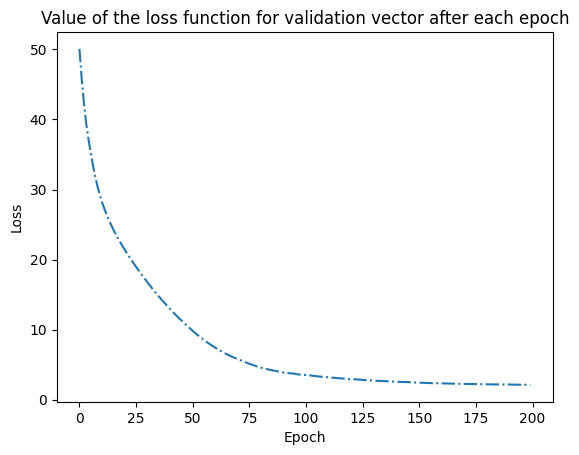

array([[-0.23257727,  9.01698619,  4.64016652,  2.48686802, 10.12077573,
         5.37019887,  5.22278117,  1.62801948, 13.60064421,  4.26004463,
         4.32212085,  8.90998901,  7.52935514,  4.6920385 ,  8.48803886,
         9.63125515,  4.06618801,  0.675054  ,  8.88139631,  1.46547021,
        12.16264168,  7.01546624,  9.43762312, 15.31934968,  6.10870506,
         7.50141346,  2.47435467,  2.38486097,  5.21777775,  6.92206877]])

In [75]:
model2 = RidgeRegr().fit(X_train, Y_train, X_val=X_val, Y_val=Y_val, eta=0.001, epochs=200)
Y_pred = model2.predict(X_val)
Y_pred